<a href="https://colab.research.google.com/github/Caterinasacco/Semantic-Segmentation-/blob/main/Segmentaz_pareti_modello_Ci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
!cp "/content/drive/MyDrive/Colab Notebooks/Segmentaz_pareti_modello_Ci.ipynb" "/content/Semantic-Segmentation-/"
%cd /content/Semantic-Segmentation-


cp: cannot create regular file '/content/Semantic-Segmentation-/': Not a directory
[Errno 2] No such file or directory: '/content/Semantic-Segmentation-'
/content


In [1]:
# Sposta nella directory corretta (già fatto, ma lo rifacciamo per sicurezza)
%cd /content/Semantic-Segmentation-

# Aggiungi il file al repository
!git add Segmentaz_pareti_modello_Ci.ipynb

# Crea un commit con un messaggio chiaro
!git commit -m "Aggiunto notebook Segmentaz_pareti_modello_Ci da Colab"

# Esegui il push sul ramo principale
!git push origin main


[Errno 2] No such file or directory: '/content/Semantic-Segmentation-'
/content
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


#Caricamento del dataset da kaggle


In [ ]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"caterinasacco","key":"2e306986162f193005572f88b3bf7ac5"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d balraj98/facades-dataset


Dataset URL: https://www.kaggle.com/datasets/balraj98/facades-dataset
License(s): other
 98% 33.0M/33.5M [00:01<00:00, 34.3MB/s]
100% 33.5M/33.5M [00:01<00:00, 23.2MB/s]


In [ ]:
!unzip facades-dataset.zip -d /content/dataset


Archive:  facades-dataset.zip
  inflating: /content/dataset/metadata.csv  
  inflating: /content/dataset/testA/1.jpg  
  inflating: /content/dataset/testA/10.jpg  
  inflating: /content/dataset/testA/100.jpg  
  inflating: /content/dataset/testA/101.jpg  
  inflating: /content/dataset/testA/102.jpg  
  inflating: /content/dataset/testA/103.jpg  
  inflating: /content/dataset/testA/104.jpg  
  inflating: /content/dataset/testA/105.jpg  
  inflating: /content/dataset/testA/106.jpg  
  inflating: /content/dataset/testA/11.jpg  
  inflating: /content/dataset/testA/12.jpg  
  inflating: /content/dataset/testA/13.jpg  
  inflating: /content/dataset/testA/14.jpg  
  inflating: /content/dataset/testA/15.jpg  
  inflating: /content/dataset/testA/16.jpg  
  inflating: /content/dataset/testA/17.jpg  
  inflating: /content/dataset/testA/18.jpg  
  inflating: /content/dataset/testA/19.jpg  
  inflating: /content/dataset/testA/2.jpg  
  inflating: /content/dataset/testA/20.jpg  
  inflating: /conten

#Librerie

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


#Preprocessing immagini e split train e test

In [ ]:
train_image = "/content/dataset/trainA"
train_mask = "/content/dataset/trainB"
test_image = "/content/dataset/testA"
test_mask = "/content/dataset/testB"


def preprocess_image(image):
    image = tf.image.resize(image, (160, 160))
    image = image / 255.0
    return image

def preprocess_mask(mask):
    mask = tf.image.resize(mask, (160, 160))
    mask = tf.image.rgb_to_grayscale(mask)  # Scala di grigi
    mask = tf.squeeze(mask, axis=-1)        # Rimuoviamo l'ultimo asse
    mask = tf.cast(mask // 25, tf.uint8)    # Normalizziamo
    mask = tf.expand_dims(mask, axis=-1)    # Aggiungiamo un asse per il canale
    return mask

train_images = tf.keras.utils.image_dataset_from_directory(
    train_image,
    image_size=(160, 160),
    batch_size=None,
    shuffle=False,
    label_mode=None
).map(preprocess_image)

test_images = tf.keras.utils.image_dataset_from_directory(
    test_image,
    image_size=(160, 160),
    batch_size=None,
    shuffle=False,
    label_mode=None
).map(preprocess_image)

train_masks = tf.keras.utils.image_dataset_from_directory(
    train_mask,
    image_size=(160, 160),
    batch_size=None,
    shuffle=False,
    label_mode=None
).map(preprocess_mask)

test_masks = tf.keras.utils.image_dataset_from_directory(
    test_mask,
    image_size=(160, 160),
    batch_size=None,
    shuffle=False,
    label_mode=None
).map(preprocess_mask)



# Allineamento delle forme
train_dataset = tf.data.Dataset.zip((train_images, train_masks))
test_dataset = tf.data.Dataset.zip((test_images, test_masks))

# Filtriamo le forme non corrispondenti
def filter_valid_shapes(image, mask):
    return tf.equal(tf.shape(image), tf.shape(mask))

train_dataset = train_dataset.filter(
    lambda img, mask: tf.reduce_all(tf.shape(img) == [160, 160, 3]) and tf.reduce_all(tf.shape(mask) == [160, 160, 1])
)
test_dataset = test_dataset.filter(
    lambda img, mask: tf.reduce_all(tf.shape(img) == [160, 160, 3]) and tf.reduce_all(tf.shape(mask) == [160, 160, 1])
)

# Shuffle, Batch, Repeat e Prefetch
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

for img, mask in train_dataset.take(1):
    print(f"Forma delle immagini: {img.shape}")
    print(f"Forma delle maschere: {mask.shape}")


Found 400 files.
Found 106 files.
Found 400 files.
Found 106 files.
Forma delle immagini: (32, 160, 160, 3)
Forma delle maschere: (32, 160, 160, 1)


#U-net


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, ReLU, MaxPooling2D, UpSampling2D, Concatenate, Input

# ✅ Funzione di operazione di convoluzione
def convolution_operation(entered_input, filters=64):
    conv1 = Conv2D(filters, kernel_size=(3, 3), padding='same')(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)

    conv2 = Conv2D(filters, kernel_size=(3, 3), padding='same')(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)

    return act2

# ✅ Funzione Encoder
def encoder(entered_input, filters=64):
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(enc1)
    return enc1, MaxPool1

# ✅ Funzione Decoder
def decoder(entered_input, skip, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

# ✅ Modello U-Net
def U_Net(Image_Size=(160, 160, 3), num_classes=10):
    input1 = Input(shape=Image_Size)

    # Encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)

    # Bottleneck
    conv_block = convolution_operation(encoder_4, 64*16)

    # Decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)

    out = Conv2D(num_classes, 1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = models.Model(inputs=input1, outputs=out)
    return model

# ✅ Costruzione del Modello
input_shape = (160, 160, 3)
model = U_Net(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

steps_per_epoch = 400 // 32  # Calcola il numero di batch per epoca
validation_steps = 106 // 32

history= model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=50
)


Epoch 1/50


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 160, 160, 1), output.shape=(None, 160, 160, 10)

#Data augmentation

In [ ]:
def data_augmentation(image, mask):
    seed = (tf.random.uniform(shape=(), minval=0, maxval=1000, dtype=tf.int32), 0)
    mask = tf.cast(mask, tf.float32)

    # Rotazione casuale
    image = tf.image.stateless_random_flip_left_right(image, seed=seed)
    mask = tf.image.stateless_random_flip_left_right(mask, seed=seed)

    image = tf.image.stateless_random_flip_up_down(image, seed=seed)
    mask = tf.image.stateless_random_flip_up_down(mask, seed=seed)

    # Modifica luminosità
    image = tf.image.stateless_random_brightness(image, max_delta=0.1, seed=seed)

    # Cropping casuale unificato
    combined = tf.concat([image, mask], axis=-1)
    combined = tf.image.stateless_random_crop(combined, size=[128, 128, 4], seed=seed)

    # Separiamo immagine e maschera
    image = combined[:, :, :3]
    mask = combined[:, :, 3:]

    # Ridimensioniamo a (160, 160)
    image = tf.image.resize(image, (160, 160))
    mask = tf.image.resize(mask, (160, 160))
    mask = tf.cast(mask, tf.uint8)

    return image, mask


#Applica Data Augmentation SOLO al dataset di training
train_dataset = train_dataset.map(
    lambda img, mask: data_augmentation(img, mask),
    num_parallel_calls=tf.data.AUTOTUNE
)


Found 400 files.
Found 106 files.
Found 400 files.
Found 106 files.
Forma delle immagini: (32, 160, 160, 3)
Forma delle maschere: (32, 160, 160, 1)


#Addestramento modello
Il modello segue l'approccio Encoder-Bottleneck-Decoder, caratteristico della U-Net:

Encoder: Estrae caratteristiche a più livelli tramite convoluzioni e pooling.

Bottleneck: Cattura le caratteristiche globali dell'immagine in una rappresentazione compatta.

Decoder: Ricostruisce la maschera di segmentazione utilizzando upsampling e concatenazione con i livelli corrispondenti dell'encoder.

In [ ]:
inputs = layers.Input(shape=(160, 160, 3))

# Encoder
c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
p1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
p2 = layers.MaxPooling2D((2, 2))(c2)

# Bottleneck
b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b1)

# Decoder
u1 = layers.UpSampling2D((2, 2))(b1)
u1 = layers.Concatenate()([u1, c2])
c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

u2 = layers.UpSampling2D((2, 2))(c3)
u2 = layers.Concatenate()([u2, c1])
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

outputs = layers.Conv2D(10, (1, 1), activation='softmax')(c4)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
]
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=200,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/200
     13/Unknown 77s 3s/step - accuracy: 0.2691 - loss: 2.2417   

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.2753 - loss: 2.2362 - val_accuracy: 0.4096 - val_loss: 1.8935 - learning_rate: 1.0000e-04
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 433ms/step - accuracy: 0.4202 - loss: 1.8630 - val_accuracy: 0.4100 - val_loss: 1.7719 - learning_rate: 1.0000e-04
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 433ms/step - accuracy: 0.4115 - loss: 1.7641 - val_accuracy: 0.4159 - val_loss: 1.7146 - learning_rate: 1.0000e-04
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 430ms/step - accuracy: 0.4251 - loss: 1.7147 - val_accuracy: 0.4207 - val_loss: 1.6705 - learning_rate: 1.0000e-04
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - accuracy: 0.4245 - loss: 1.6785 - val_accuracy: 0.4240 - val_loss: 1.6476 - learning_rate: 1.0000e-04
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 450ms/step - accuracy: 0.4344 - loss: 1.6379 - val_accuracy: 0.4317 - val_loss: 1.5881 - learning_rate: 1.0000e-04
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 460ms/step - accuracy: 0.4

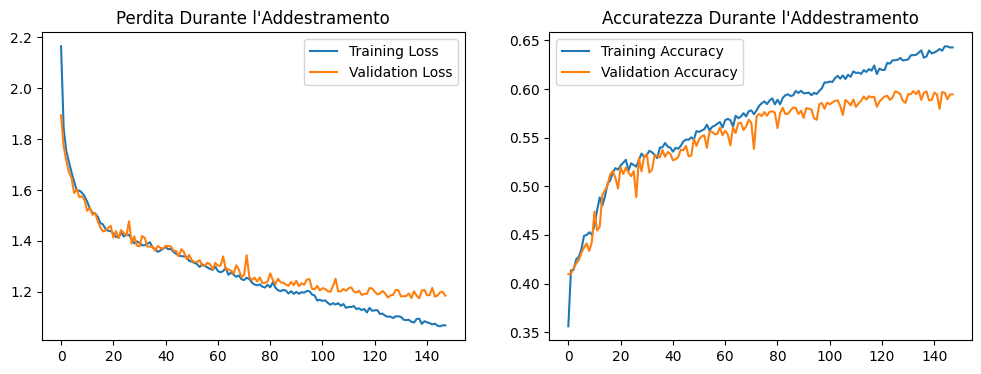

In [ ]:
#Andamento loss e accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Perdita Durante l\'Addestramento')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuratezza Durante l\'Addestramento')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


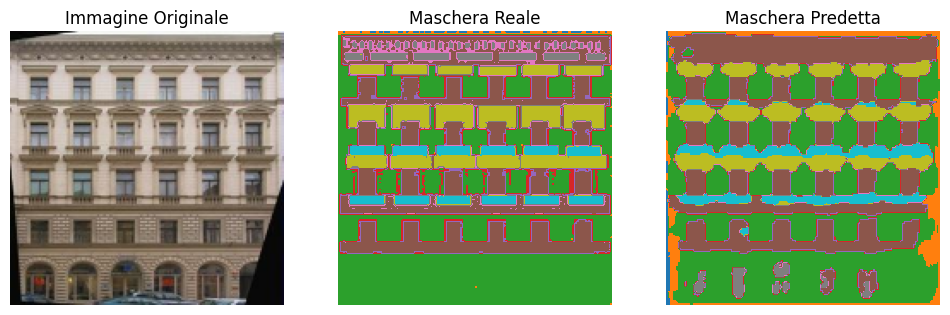

In [ ]:
#predizioni
for img, mask in test_dataset.take(1):
    predictions = model.predict(img)
    pred_mask = tf.argmax(predictions, axis=-1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img[1].numpy())
    plt.title("Immagine Originale")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask[1].numpy(), cmap='tab10')
    plt.title("Maschera Reale")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[1].numpy(), cmap='tab10')
    plt.title("Maschera Predetta")
    plt.axis("off")

    plt.show()
